## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import tensorflow.keras as keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
from sklearn import preprocessing

In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
        x = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit_transform(x)
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from tensorflow.keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    exp_name_tag = "model 01"
    print(exp_name_tag)
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [8]:
# 載入 Callbacks
"""Code Here
設定 callbacks: model checkpoint
"""
"""
# 載入 Callbacks, 並將監控目標設為 validation loss, 且只存最佳參數時的模型
"""
from tensorflow.keras.callbacks import ModelCheckpoint

model_ckpt = ModelCheckpoint(filepath="tmp00.h5", 
                             monitor="val_loss", 
                             save_best_only=True)
model_ckpt_bestonlyfalse = ModelCheckpoint(filepath="tmp01.h5", 
                             monitor="val_loss", 
                             save_best_only=False)
model_ckpt_weights_only = ModelCheckpoint(filepath="tmp02.h5", 
                             monitor="val_loss", 
                            save_weights_only=True)


In [9]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt]
         )



# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

# Load back
model = keras.models.load_model("tmp00.h5")
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)


model 01
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)     

49/49 [==============================] - 6s 113ms/step - loss: 0.3327 - accuracy: 0.9295 - val_loss: 1.7950 - val_accuracy: 0.4875
Epoch 49/50
49/49 [==============================] - 5s 111ms/step - loss: 0.3163 - accuracy: 0.9355 - val_loss: 1.8097 - val_accuracy: 0.4842
Epoch 50/50
313/313 [==============================] - 1s 3ms/step - loss: 1.4641 - accuracy: 0.4921


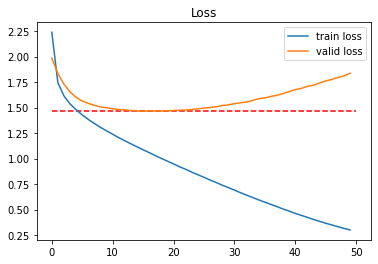

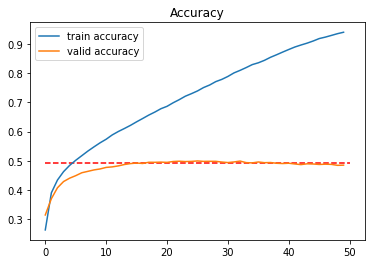

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()

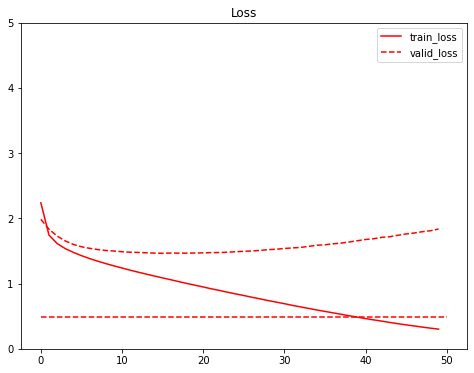

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k","pink","c"]

plt.figure(figsize=(8,6))

plt.plot(range(len(train_loss)),train_loss, label="train_loss",linestyle="-", color=color_bar[0])
plt.plot(range(len(valid_loss)),valid_loss, label="valid_loss",linestyle='--', color=color_bar[0])
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='-*-')
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

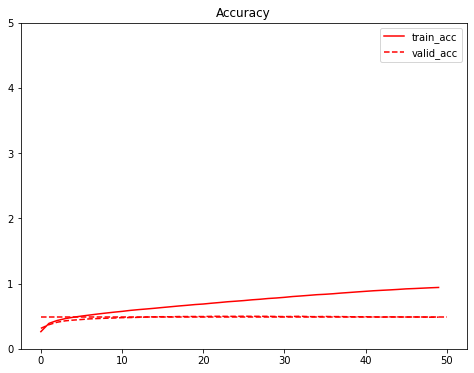

In [12]:
color_bar = ["r", "g", "b", "y", "m", "k","pink","c"]

plt.figure(figsize=(8,6))

plt.plot(range(len(train_loss)),train_acc, label="train_acc",linestyle="-", color=color_bar[0])
plt.plot(range(len(valid_loss)),valid_acc, label="valid_acc",linestyle='--', color=color_bar[0])
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.title("Accuracy")
plt.ylim([0, 5])
plt.legend()
plt.show()

# best_only False

In [13]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt_bestonlyfalse]
         )



# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

# Load back
model = keras.models.load_model("tmp01.h5")
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)



model 01
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)     

49/49 [==============================] - 17s 339ms/step - loss: 0.3205 - accuracy: 0.9343 - val_loss: 1.8116 - val_accuracy: 0.4830
Epoch 49/50
49/49 [==============================] - 20s 409ms/step - loss: 0.3045 - accuracy: 0.9409 - val_loss: 1.8202 - val_accuracy: 0.4841
Epoch 50/50
313/313 [==============================] - 2s 5ms/step - loss: 1.8484 - accuracy: 0.4792


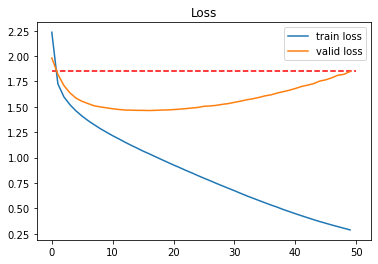

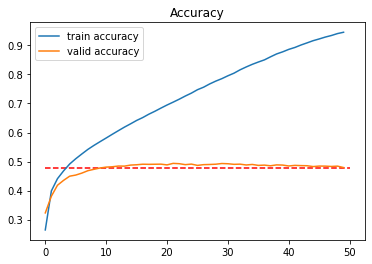

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()

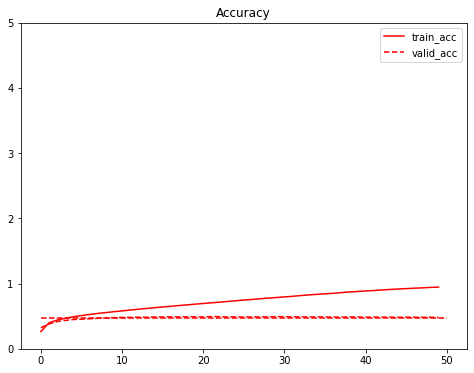

In [15]:
color_bar = ["r", "g", "b", "y", "m", "k","pink","c"]

plt.figure(figsize=(8,6))

plt.plot(range(len(train_loss)),train_acc, label="train_acc",linestyle="-", color=color_bar[0])
plt.plot(range(len(valid_loss)),valid_acc, label="valid_acc",linestyle='--', color=color_bar[0])
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.title("Accuracy")
plt.ylim([0, 5])
plt.legend()
plt.show()

# weights only true

In [16]:
results = {}

"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt_weights_only]
         )



# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

# Load back
model.load_weights("tmp02.h5")# ＃＃＃＃＃load weights
y_predict=model.predict(x_test)




model 01
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_8 (Batch (None, 128)     

49/49 [==============================] - 5s 109ms/step - loss: 0.3378 - accuracy: 0.9287 - val_loss: 1.7756 - val_accuracy: 0.4870
Epoch 49/50
49/49 [==============================] - 5s 110ms/step - loss: 0.3218 - accuracy: 0.9340 - val_loss: 1.7915 - val_accuracy: 0.4858
Epoch 50/50
49/49 [==============================] - 5s 105ms/step - loss: 0.3060 - accuracy: 0.9395 - val_loss: 1.8107 - val_accuracy: 0.4885


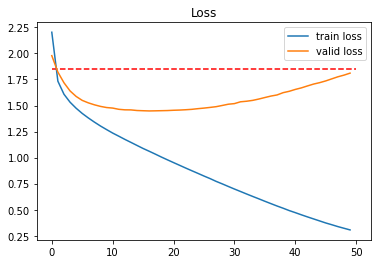

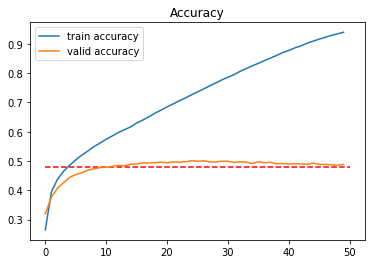

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()

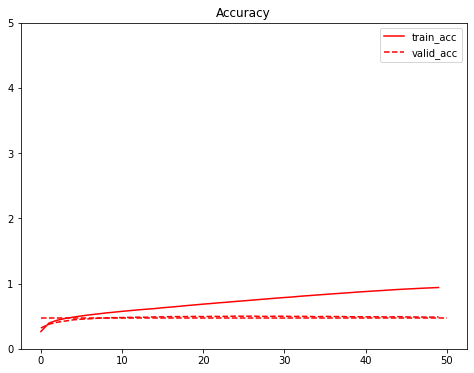

In [18]:
color_bar = ["r", "g", "b", "y", "m", "k","pink","c"]

plt.figure(figsize=(8,6))

plt.plot(range(len(train_loss)),train_acc, label="train_acc",linestyle="-", color=color_bar[0])
plt.plot(range(len(valid_loss)),valid_acc, label="valid_acc",linestyle='--', color=color_bar[0])
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.title("Accuracy")
plt.ylim([0, 5])
plt.legend()
plt.show()

In [19]:
# 預測結果是以機率表示
y_predict[9999][0]

0.0016752147

In [20]:
# 超過0.5 為1 小於0.5為0
len(y_predict[0])
len(y_predict)
for i in range(10000):
    for j in range(10):
        if y_predict[i][j]<0.5:
            y_predict[i][j]=0
        else:
            y_predict[i][j]=1
y_predict

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [21]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [22]:
#計算準確度
n=0
m=len(y_predict[0])*len(y_predict)
for i in range(10000):
    for j in range(10):
        if y_predict[i][j]==y_test[i][j]:
            n=n+1
        else:
            n=n
n/m

0.90674